In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


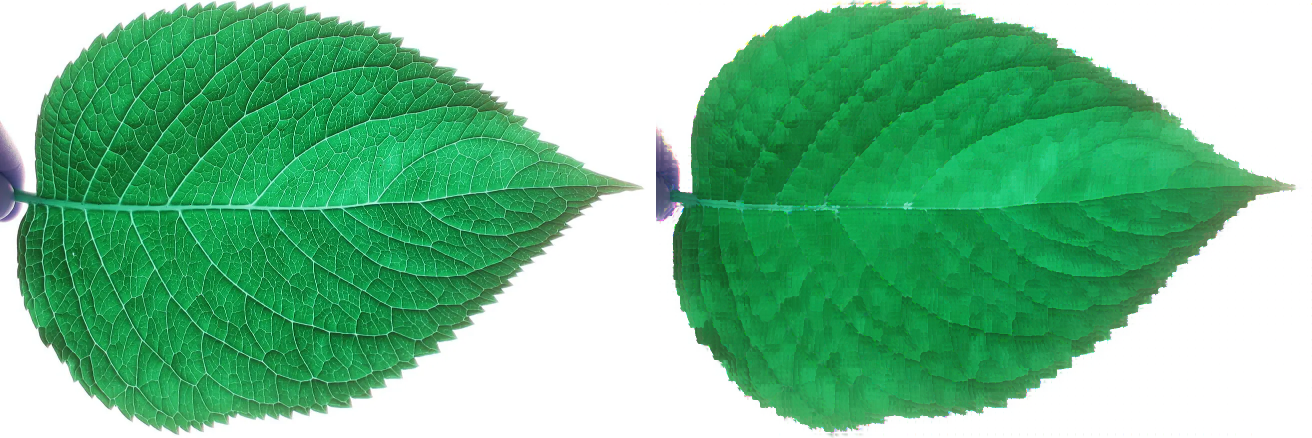

In [ ]:
import numpy as np
import cv2
from numba import cuda
import numba
from google.colab.patches import cv2_imshow
@cuda.jit
def kuwahara_single_channel_kernel(channel, output_channel, height, width, omega):
    x, y = cuda.grid(2)
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    shared_size = 50
    shared_channel = cuda.shared.array((shared_size, shared_size), numba.float32)

    shared_x = tx + omega
    shared_y = ty + omega

    if x < width and y < height:
        shared_channel[shared_y, shared_x] = channel[y, x]
    else:
        shared_channel[shared_y, shared_x] = 0

    if tx < omega:
        if x >= omega:
            shared_channel[shared_y, shared_x - omega] = channel[y, x - omega]
        if x + cuda.blockDim.x < width:
            shared_channel[shared_y, shared_x + cuda.blockDim.x] = channel[y, x + cuda.blockDim.x]

    if ty < omega:
        if y >= omega:
            shared_channel[shared_y - omega, shared_x] = channel[y - omega, x]
        if y + cuda.blockDim.y < height:
            shared_channel[shared_y + cuda.blockDim.y, shared_x] = channel[y + cuda.blockDim.y, x]

    cuda.syncthreads()

    means = cuda.local.array(4, numba.float32)
    variances = cuda.local.array(4, numba.float32)
    counts = cuda.local.array(4, numba.int32)

    for k in range(4):
        means[k] = 0.0
        variances[k] = 0.0
        counts[k] = 0

    for dx in range(-omega, omega + 1):
        for dy in range(-omega, omega + 1):
            val = shared_channel[shared_y + dy, shared_x + dx]

            if dy <= 0 and dx <= 0:
                means[0] += val
                variances[0] += val * val
                counts[0] += 1
            if dy <= 0 and dx >= 0:
                means[1] += val
                variances[1] += val * val
                counts[1] += 1
            if dy >= 0 and dx <= 0:
                means[2] += val
                variances[2] += val * val
                counts[2] += 1
            if dy >= 0 and dx >= 0:
                means[3] += val
                variances[3] += val * val
                counts[3] += 1

    for k in range(4):
        if counts[k] > 0:
            means[k] /= counts[k]
            variances[k] = (variances[k] / counts[k]) - (means[k] * means[k])

    min_variance = variances[0]
    min_k = 0
    for k in range(1, 4):
        if variances[k] < min_variance:
            min_variance = variances[k]
            min_k = k

    if x < width and y < height:
        output_channel[y, x] = means[min_k]

def kuwahara_filter_separate_channels(image, omega):
    r, g, b = cv2.split(image.astype(np.float32))
    r_gpu = cuda.to_device(r)
    g_gpu = cuda.to_device(g)
    b_gpu = cuda.to_device(b)

    output_r = cuda.device_array(r.shape, dtype=np.float32)
    output_g = cuda.device_array(g.shape, dtype=np.float32)
    output_b = cuda.device_array(b.shape, dtype=np.float32)

    height, width = r.shape
    threads_per_block = (16, 16)
    blocks_per_grid = ((width + threads_per_block[0] - 1) // threads_per_block[0],
                       (height + threads_per_block[1] - 1) // threads_per_block[1])

    kuwahara_single_channel_kernel[blocks_per_grid, threads_per_block](r_gpu, output_r, height, width, omega)
    kuwahara_single_channel_kernel[blocks_per_grid, threads_per_block](g_gpu, output_g, height, width, omega)
    kuwahara_single_channel_kernel[blocks_per_grid, threads_per_block](b_gpu, output_b, height, width, omega)

    filtered_r = output_r.copy_to_host().astype(np.uint8)
    filtered_g = output_g.copy_to_host().astype(np.uint8)
    filtered_b = output_b.copy_to_host().astype(np.uint8)

    filtered_image = cv2.merge([filtered_r, filtered_g, filtered_b])
    return filtered_image

image_path = '/content/gdrive/MyDrive/HPC/Proj/leaf_area.jpg'
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image at path '{image_path}' not found.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

filtered_image = kuwahara_filter_separate_channels(image_rgb, omega=9)

height, width = image_rgb.shape[:2]
filtered_image_resized = cv2.resize(filtered_image, (width // 2, height // 2))
image_rgb_resized = cv2.resize(image_rgb, (width // 2, height // 2))
concatenated_image = np.concatenate((image_rgb_resized, filtered_image_resized), axis=1)
cv2_imshow(concatenated_image)


In [ ]:
import time

def measure_performance(image, omega_values):
    timings = {}
    for omega in omega_values:
        start_time = time.time()

        filtered_image = kuwahara_filter_separate_channels(image, omega=omega)
        cuda.synchronize()
        end_time = time.time()
        time_taken = end_time - start_time
        timings[omega] = time_taken


    return timings

omega_values = [1, 3, 5,7,9]

performance_timings = measure_performance(image_rgb, omega_values)

print("\nPerformance Timings for Different Omega Values:")
for omega, timing in performance_timings.items():
    print(f"Omega: {omega}, Time: {timing:.4f} seconds")


Performance Timings for Different Omega Values:
Omega: 1, Time: 0.0510 seconds
Omega: 3, Time: 0.0484 seconds
Omega: 5, Time: 0.0441 seconds
Omega: 7, Time: 0.0497 seconds
Omega: 9, Time: 0.0586 seconds
